# IMPORTS

In [43]:
import pandas as pd

In [44]:
df = pd.read_csv("nuclear_dataset.csv", usecols=['C1', 'C2', 'C3', 'C4'])
df

,C1,C2,C3,C4
0,0.60,0.93,0.00,0.73
1,0.66,0.55,0.45,0.49
2,1.00,0.45,0.57,0.50
3,0.48,0.87,0.00,0.75
4,0.62,0.40,0.56,0.50
5,0.78,0.27,0.71,0.50
6,0.40,0.90,0.00,0.82
7,0.64,0.44,0.54,0.54
8,0.65,0.30,0.71,0.55
9,0.45,0.86,0.00,0.73


# Informacje preferencyjne

W ramach informacji preferencyjnych należy ocenić parami warianty 0 i 15 (W skutek wyczerpywania się złóż materiałów radioaktywnych, elektrownie mogą zacząć korzystać z bardziej ubogich złóż, co przełoży się na zwiększenie ilości odpadów radioaktywnych) oraz 10 i 17 (Inflacja może znacząco wzrosnąć w przyszłości, więc minimalizacja kosztów w przyszłości powinny być ważniejsza niż koszty aktualne)

In [45]:
df[df.index.isin([0, 15, 10, 17])]

,C1,C2,C3,C4
0,0.60,0.93,0.00,0.73
10,0.61,0.54,0.38,0.49
15,0.44,0.95,0.00,0.90
17,0.76,0.06,1.00,0.60


Wariant 0 > Wariant 15 - $ U(W0) > U(W15) $

Wariant 10 > Wariant 17 - $ U(W10) > U(W17) $



In [46]:
PREFERENCES = [
    [0, 15],  # 0 > 15
    [10, 17],  # 10 > 17
    [18, 19],
    [21, 19],
    [19, 16],
]

In [47]:
from pulp import *

In [48]:
# Utworzenie problemu UTA-GMS
problem = LpProblem("uta-gms", LpMaximize)

# Utworzenie zmiennej maksymalizowanej
epsilon = LpVariable("epsilon")

# Utworzenie zmiennych decyzyjnych dla każdego kryterium w problemie programowania matematycznego
decision_variables = {}
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]

# Wagi na danych kryteriach
# problem += decision_variables['C3'][0] == 2*decision_variables['C1'][0]
# problem += decision_variables['C2'][0] == 3*decision_variables['C1'][0]

# Dodanie ograniczenia na normalizację (maksymalna użyteczność globalna równa 1)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o minimalnych wartościach jest najlepszy
problem += lpSum([x[0] for x in decision_variables.values()]) == 1

# Dodanie ograniczenia na normalizację (minimalna użyteczność globalna równa 0)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o maksymalnych wartościach jest najgorszy
problem += lpSum([x[-1] for x in decision_variables.values()]) == 0

# Dodanie ograniczeń na monotoniczność funkcji cząstkowych
# W problemie używana jest funkcja ogólna, więc nie ma potrzeby wyliczania interpolacji liniowej
# Wystarczy dodać ograniczenia, które gwarantują, że kolejne zmienne decyzyjne mają nierosnące wartości użyteczności
for column in df.columns:
    for i in range(len(decision_variables[column])-1):
        problem += decision_variables[column][i] >= decision_variables[column][i+1]

# Dodanie ograniczeń związanych z preferencjami decydenta
for preference in PREFERENCES:
    alt_1 = df.loc[preference[0]].to_dict()
    alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        
    alt_2 = df.loc[preference[1]].to_dict()
    alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]

    problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon

problem += epsilon
problem.solve(solver=GLPK(msg=False))
solution = {variable.name: variable.varValue for variable in problem.variables()}

# Wykresy użyteczności

In [49]:
import matplotlib.pyplot as plt

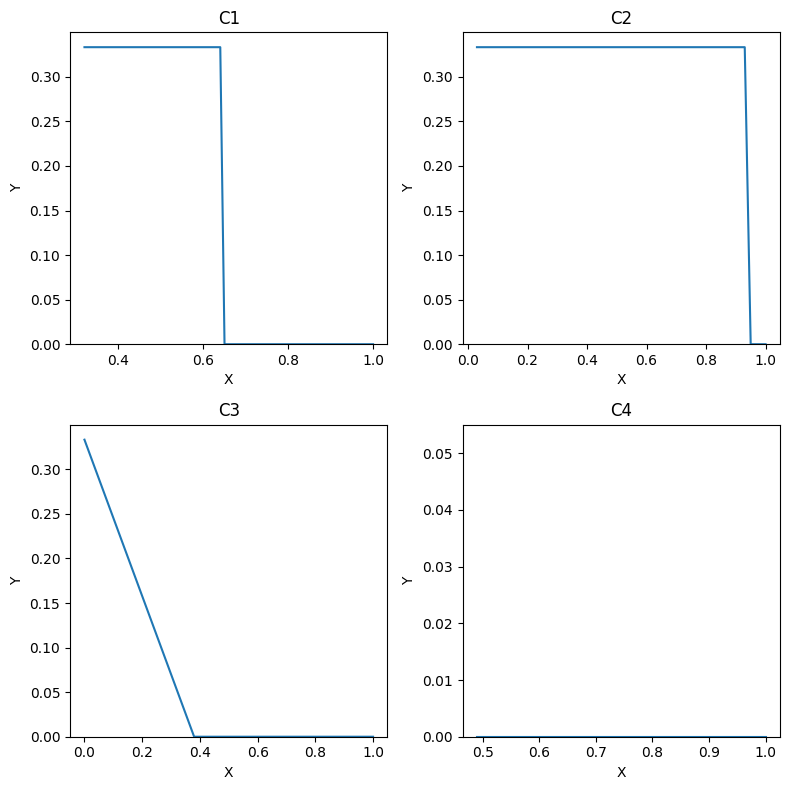

In [50]:
utilities = {criterion: [] for criterion in df.columns}
for k, v in solution.items():
    if k.startswith("x_"):
        criterion = k.split("_")[1]
        x = float(k.split("_")[2])
        y = v
        utilities[criterion].append((x, y))

num_plots = len(utilities)
cols = 2
rows = num_plots // cols
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, (k, v) in enumerate(utilities.items()):
    x = [point[0] for point in v]
    y = [point[1] for point in v]
    row = i // cols
    col = i % cols
    ax = axs[row, col]
    
    ax.plot(x, y)
    ax.set_title(k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Wartości użyteczności oraz ranking wszystkich wariantów

In [51]:
global_utilities = []
for k, alternative in df.iterrows():
    s = 0
    for column in df.columns:
        s += next((point[1] for point in utilities[column] if point[0] == alternative[column]), None)
    global_utilities.append(s)

df_u = df.copy()
df_u['U'] = global_utilities
df_u['rank'] = df_u['U'].rank(ascending=False, method='min')
df_u.sort_values(by='rank')

,C1,C2,C3,C4,U,rank
0,0.60,0.93,0.00,0.73,0.999999,1.0
18,0.35,0.91,0.00,0.98,0.999999,1.0
9,0.45,0.86,0.00,0.73,0.999999,1.0
6,0.40,0.90,0.00,0.82,0.999999,1.0
21,0.32,0.83,0.00,0.94,0.999999,1.0
3,0.48,0.87,0.00,0.75,0.999999,1.0
22,0.59,0.24,0.70,0.63,0.666666,7.0
7,0.64,0.44,0.54,0.54,0.666666,7.0
15,0.44,0.95,0.00,0.90,0.666666,7.0
10,0.61,0.54,0.38,0.49,0.666666,7.0


# Wartość funkcji celu

In [52]:
solution['epsilon']

0.333333

# Analiza możliwych i koniecznych relacje preferencji za pomocą metody UTA-GMS

Dla każdej pary wariantów należy przeprowadzić badanie:
1. Czy istnieje między nimi konieczna relacja preferencji
2. Jeżeli relacja konieczna nie zachodzi, to czy istnieje relacje możliwa

In [53]:
%%time
NECESSARY = 1
POSSIBLE = 2

alternatives = df.index
df_relations = pd.DataFrame(0, index=alternatives, columns=alternatives)
for alt_1_id in alternatives:
    for alt_2_id in alternatives:
        if alt_1_id == alt_2_id:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue

        # Badanie relacji koniecznej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        # problem += decision_variables['C3'][0] == 2*decision_variables['C1'][0]
        # problem += decision_variables['C2'][0] == 3*decision_variables['C1'][0]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację konieczną
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_2_variables) >= lpSum(alt_1_variables) + epsilon
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value <= 0:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue
        
        # Badanie relacji możliwej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        # problem += decision_variables['C3'][0] == 2*decision_variables['C1'][0]
        # problem += decision_variables['C2'][0] == 3*decision_variables['C1'][0]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację możliwą
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables)
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value > 0:
            df_relations.loc[alt_1_id, alt_2_id] = POSSIBLE

CPU times: user 6.43 s, sys: 358 ms, total: 6.78 s
Wall time: 9.01 s


In [54]:
df_relations

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,2,1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,2,2,1,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,2,2,1,2,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5,2,2,2,2,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
6,2,2,2,2,2,2,1,2,2,2,...,2,2,2,2,2,2,2,2,2,2
7,2,2,2,2,2,2,2,1,2,2,...,2,2,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2,1,2,...,2,2,2,2,2,2,2,2,2,2
9,1,2,2,1,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2


# Diagram Hasse relacji koniecznych

![graph](./graph.svg)

# Reprezentatywna funkcja użyteczności